In [61]:
# MiBand에서 추출한 데이터를 Excel을 통해 모두 csv, UTF-8로 저장할 것
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet #check file encoding

# Laplace Mechanism
from scipy.stats import laplace
from scipy.stats import gamma
from sympy import Symbol, exp, sqrt, pi, Integral
import math


# Paillier Homomorphic Encryption
import phe
from phe import paillier

print('Import Complete')

Import Complete


In [47]:
%%time
time_range = [10,11,12,13,14,15,16,17,18,19,20]
data_dir = '/home/hp/jupyter/ljh/eHealthPython/data/'

# 디렉토리 내의 csv 파일(걸음수 데이터)을 모두 가져와 리스트에 담는다
def get_file_list(dirname):
    f_list = []
    for (path, dir, files) in os.walk(dirname):
        for filename in files:
            ext = os.path.splitext(filename)[-1]
            if ext == '.csv' or ext =='.xls':
                f_list.append(os.path.join(path, filename))
    return f_list
file_list = get_file_list(data_dir)


# 파일의 인코딩 확인
def find_encoding(file):
    r_file = open(file, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc


# 라플라스 메커니즘으로 노이즈 추가
def lap_mechanism(original_data=[], loc=0, scale=0):
    def laprnd(loc,scale):
        s = laplace.rvs(loc, scale, None)
        return s
    
    N = 79
    sensitivity, epsilon = 7000, 1.0
    slot_size = len(original_data)
    noisy_data = list(map(lambda i: i + laprnd(0, (sensitivity/N)/(epsilon/slot_size)), original_data))
    return list(np.around(np.array(noisy_data)))


# 라플라스 메커니즘의 infinite divisibility(무한 분할성)을 활용한 감마 분포의 실수 차를 노이즈로 추가
def lap_mechanism_gamma(original_data=[], loc=0, scale=0):
    def gammarnd(shpae, scale):
        def two_gammarnd_diff1():
            r = gamma.rvs(eshape, eloc, escale, size=2)

        rnd_diff_list=[]

        for i in range(len(original_data)):
            r = gamma.rvs(shape, 0, scale, 2)
            rnd_diff_list.append(r[0]-r[1])
        return rnd_diff_list
    
    N = 79    #number of people
#     slot_size = 66    #number of time period
    slot_size = np.count_nonzero(~np.isnan(original_data))    #number of salient point
    
    sensitivity, epsilon = 7000, 1.0
    shape,scale = 1/N, (sensitivity/N)/(epsilon/slot_size)
    Gamma = gamma(a =  shape, scale = scale)
    print(shape, scale)

    gamma_noise_list = gammarnd(shape, scale)

    noisy_data = np.array(original_data) + np.array(gamma_noise_list)
    return noisy_data



# Paillier - Homomorphic Encryption Scheme
# encrypt with public_key & decrypt with private_key
class Paillier:
    def __init__(self):
        self.pub_key = 0
        self.priv_key = 0
    
    def setKey(self, pub_key, priv_key):
        self.pub_key, self.priv_key = paillier.generate_paillier_keypair(n_length=2048)
        
    def enc(self, data_lst=[]):
        encrypted_data_lst = []
        for data in data_lst:
            encrypted_data_lst.append(self.pub_key.encrypt(data))
        return encrypted_data_lst
    
    def func_chk(self, data_lst=[]):
        print('original data sum :',np.around(sum(data_lst)), 'encrypted data sum :', np.around(self.priv_key.decrypt(sum(self.enc(data_lst)))))
        print('original data average :', np.around(sum(data_lst)/len(data_lst)), 'encrypted data average :', np.around(self.priv_key.decrypt(sum(self.enc(data_lst))/len(self.enc(data_lst)))))


def histogram_generate(df):
    all_day_histogram_original_dict = dict()
    all_day_histogram_noisy_dict = dict()
    hours=[10,11,12,13,14,15,16,17,18,19,20]

    for date in dates:
        hour_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for row in df.itertuples(index=False, name='Pandas'):
            if getattr(row, 'Date')==date:
                hour_data[getattr(row, 'Hour')-10] += getattr(row, 'Steps')
    #     print(np.around(np.array(hour_data)/6))
        all_day_histogram_original_dict[date] = list(np.around(np.array(hour_data)/6))

    for date in dates:
        original_data = all_day_histogram_original_dict[date]
        noisy_data = lap_mechanism(all_day_histogram_original_dict[date])
        all_day_histogram_noisy_dict[date] = noisy_data
#         print(date)
#         print(original_data)
#         print(noisy_data)
    graph_compare(all_day_histogram_original_dict[dates[0]], lap_mechanism(all_day_histogram_original_dict[dates[0]]), 0)
    
    return all_day_histogram_original_dict, all_day_histogram_noisy_dict


def sp_generate(arr):
    diff = np.diff(arr)
    diff_list = [1 if i>0 else(-1 if i<0  else 0) for i in diff]
    
    stack = []
    idx_list = []
    res_list = []

    for i in range(len(diff_list)):
        if i==0:
            stack.append(diff_list[i])
            idx_list.append(i)
        if diff_list[i] not in stack:
            stack.pop()
            stack.append(diff_list[i])
            idx_list.append(i)
        if i == len(diff_list)-1:
            idx_list.append(i+1)

    idx_list = np.array(idx_list)
    for i in idx_list:
        res_list.append(arr[i])
    arr_copy = arr.copy()

    for i in range(len(arr_copy)):
        if i not in idx_list:
            arr_copy[i] = np.nan

#     print('salient point 갯수 :', len(idx_list))
#     print('원본 데이터 갯수 :', len(arr))
#     print('salient point ->', arr_copy)
    return arr_copy


# 원본과 노이즈 추가된 데이터의 그래프 비교
def graph_compare(original_data, noisy_data, flag):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.rcParams['lines.linewidth'] = 2
#     plt.rcParams['lines.color'] = 'r'
    plt.rcParams['axes.grid'] = True 
    if flag==0:
        time_range=[10,11,12,13,14,15,16,17,18,19,20]
        plt.plot(time_range, original_data, time_range, noisy_data, 'r-')
    elif flag==1:
        time_range= list(np.arange(66))
        plt.scatter(np.arange(len(noisy_data)), noisy_data)
        plt.plot(time_range, original_data)
    plt.xticks(time_range, rotation=70)
    plt.ylim(-500,max(noisy_data)+500)
    
    plt.show()
  

print('Function Import Complete')

Function Import Complete
CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 811 µs


In [4]:
%%time
# test code for encoding
file_list.sort()
for file in file_list:
    print(file, '\t(',find_encoding(file),')')
    
print('\nGet File List Complete')

/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2018.10~2019.2).csv 	( utf-8 )
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.3).csv 	( utf-8 )
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.4).csv 	( utf-8 )
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.5).csv 	( utf-8 )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2018.11).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2018.12).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.2).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.3).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.4).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.5).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.6).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.7).csv 	( ascii )
/home/hp/jupyter/ljh/eHealthPython/data/mrstep(2019.3).csv 	( utf-8 )
/home/hp/jupyter/ljh/eHealthPython/data/mrstep(2019.6).csv 	( utf-8 )
/h

In [5]:
%%time
# Steps Timestamp Date Time >> Steps Timestamp Date Datetime Hourabs
# 걸음 타임스탬프 날짜 시간 >> Steps Timestamp Date Datetime Hour
index = 0
for file in file_list:
    my_encoding = find_encoding(file)
    if 'knd' in file or 'smstep(2019.5)' in file or 'smstep(2019.6)' in file:
        df = pd.read_csv(file, sep=',', encoding=my_encoding)
        del df['Time']
        df['Timestamp'] = df['Timestamp'].astype(str).apply(lambda x: x[0:-3])
#         df['Timestamp'] = df['Timestamp'].astype(str).str.slice(0:-3)

        df['Date'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').date())
        df['Datetime'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul'))
        df['Hour'] = df['Timestamp'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').strftime('%H'))
    else:
        df = pd.read_csv(file, sep=';', encoding=my_encoding)
        df.columns = ['걸음', '타임스탬프', '날짜', '시간']
        del df['시간']
        df['타임스탬프'] = df['타임스탬프'].astype(str).apply(lambda x: x[0:-3])
        df['날짜'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').date())
        df['Datetime'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul'))
        df['Hour'] = df['타임스탬프'].astype(int).apply(lambda y : pd.Timestamp(y, unit='s', tz='Asia/Seoul').strftime('%H'))
        df.columns = ['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']
    index+=1
    print(index,'/',len(file_list), '(', file, ')', '\n', df.head())
#     df.to_csv(file)
    df.to_csv(file, index=False)
    
print('\nFile Preprocess Complete')

1 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/hjstep(2018.10~2019.2).csv ) 
    Steps   Timestamp        Date                  Datetime Hour
0      0  1540199838  2018-10-22 2018-10-22 18:17:18+09:00   18
1      0  1540200180  2018-10-22 2018-10-22 18:23:00+09:00   18
2     62  1540200780  2018-10-22 2018-10-22 18:33:00+09:00   18
3     62  1540201380  2018-10-22 2018-10-22 18:43:00+09:00   18
4    598  1540201980  2018-10-22 2018-10-22 18:53:00+09:00   18
2 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.3).csv ) 
    Steps   Timestamp        Date                  Datetime Hour
0      0  1551448717  2019-03-01 2019-03-01 22:58:37+09:00   22
1      0  1551452340  2019-03-01 2019-03-01 23:59:00+09:00   23
2      0  1551501332  2019-03-02 2019-03-02 13:35:32+09:00   13
3      0  1551507173  2019-03-02 2019-03-02 15:12:53+09:00   15
4      0  1551522655  2019-03-02 2019-03-02 19:30:55+09:00   19
3 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.4).csv ) 
    Steps

19 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/smstep(2019.6).csv ) 
    Steps   Timestamp        Date                  Datetime Hour
0      0  1559350860  2019-06-01 2019-06-01 10:01:00+09:00   10
1      0  1559351460  2019-06-01 2019-06-01 10:11:00+09:00   10
2      0  1559352060  2019-06-01 2019-06-01 10:21:00+09:00   10
3      0  1559352660  2019-06-01 2019-06-01 10:31:00+09:00   10
4      0  1559353260  2019-06-01 2019-06-01 10:41:00+09:00   10
20 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/ytstep(2018.10~2019.2).csv ) 
    Steps   Timestamp        Date                  Datetime Hour
0    880  1539219660  2018-10-11 2018-10-11 10:01:00+09:00   10
1    880  1539220260  2018-10-11 2018-10-11 10:11:00+09:00   10
2    880  1539220860  2018-10-11 2018-10-11 10:21:00+09:00   10
3    880  1539221460  2018-10-11 2018-10-11 10:31:00+09:00   10
4    880  1539222060  2018-10-11 2018-10-11 10:41:00+09:00   10
21 / 22 ( /home/hp/jupyter/ljh/eHealthPython/data/ytstep(2019.3).csv ) 
    St

In [6]:
%%time
# 하루 누적 걸음수가 4000 미만인 경우, 영향력 없는 데이터로 간주하고 제외
# 10:00 ~ 20:00 사이에 10분간격으로 데이터 측정하여, 하루에 66개의 데이터가 모이지 않은 경우, 영향력 없는 데이터로 간주하고 제외
people_num=0
avg_data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
index = 0
slot_size = 66
user_list = ['hj', 'knd', 'sm', 'mr', 'yt']
user_data_count = {'hjstep': 0, 'kndstep': 0, 'smstep':0 , 'mrstep': 0, 'ytstep': 0}

for file in file_list:
#     df = pd.read_csv(file, sep=',', index_col='Datetime', parse_dates=True)
    df = pd.read_csv(file, sep=',')
    df = df.loc[df.Hour.between(10,20)]
    dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==66].index)
#     print(dates, '<',len(dates), '>')

    for row in df.itertuples():
        if getattr(row, 'Date') not in dates:
            df.drop(row.Index, inplace=True)
    
    selected_df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
    people_num+=len(selected_df.groupby(selected_df['Date']))
    
    for key in user_data_count.keys():
        if key in file:
            user_data_count[key] += len(selected_df.groupby(selected_df['Date']))
    # test with one file code 합쳐서 들어갈 곳
    
    
    
    index+=1
    print(file,'    ', index,'/',len(file_list),'    ', len(selected_df.groupby(selected_df['Date'])))
print('total people num :', people_num)

# print(user_data_dict)

/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2018.10~2019.2).csv      1 / 22      79
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.3).csv      2 / 22      18
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.4).csv      3 / 22      19
/home/hp/jupyter/ljh/eHealthPython/data/hjstep(2019.5).csv      4 / 22      17
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2018.11).csv      5 / 22      2
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2018.12).csv      6 / 22      3
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.2).csv      7 / 22      5
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.3).csv      8 / 22      9
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.4).csv      9 / 22      14
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.5).csv      10 / 22      9
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.6).csv      11 / 22      4
/home/hp/jupyter/ljh/eHealthPython/data/kndstep(2019.7).csv      12 / 22      5
/home/hp/jupyter/ljh/eHealthPython/dat

In [7]:
%%time
# 1. test with one file

slot_size = 66

# df = pd.read_csv(file_list[0], sep=',', index_col='Datetime', parse_dates=True)
df = pd.read_csv(file_list[0], sep=',')
df = df.loc[df.Hour.between(10,20)]

dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
print('당일 데이터 갯수가 66개인 날 :', len(dates))

for row in df.itertuples():
    if getattr(row, 'Date') not in dates:
        df.drop(row.Index, inplace=True)
    
df = df.groupby(df['Date']).filter(lambda y: y['Steps'].max()>4000)
print('당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날:', len(df.groupby(df['Date'])), '* 66 =', len(df.groupby(df['Date']))*66,'\n')
dates = list(df.groupby(df['Date']).size()[df.groupby(df['Date']).size()==slot_size].index)
# df

# df.set_index(df['Datetime'].astype('datetime64[ns]'), inplace=True)
# df['Steps'].resample(rule='10T').max()


df[['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']]
header = ['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour']
df[header]

당일 데이터 갯수가 66개인 날 : 109
당일 데이터가 66개인 날 중 최댓값이 4000 이상인 날: 79 * 66 = 5214 



,Steps,Timestamp,Date,Datetime,Hour
97,1827,1540256460,2018-10-23,2018-10-23 10:01:00+09:00,10
98,1827,1540257060,2018-10-23,2018-10-23 10:11:00+09:00,10
99,1837,1540257660,2018-10-23,2018-10-23 10:21:00+09:00,10
100,1855,1540258260,2018-10-23,2018-10-23 10:31:00+09:00,10
101,1926,1540258860,2018-10-23,2018-10-23 10:41:00+09:00,10
...,...,...,...,...,...
16558,5187,1551266340,2019-02-27,2019-02-27 20:19:00+09:00,20
16559,5187,1551266940,2019-02-27,2019-02-27 20:29:00+09:00,20
16560,5187,1551267540,2019-02-27,2019-02-27 20:39:00+09:00,20
16561,5719,1551268140,2019-02-27,2019-02-27 20:49:00+09:00,20


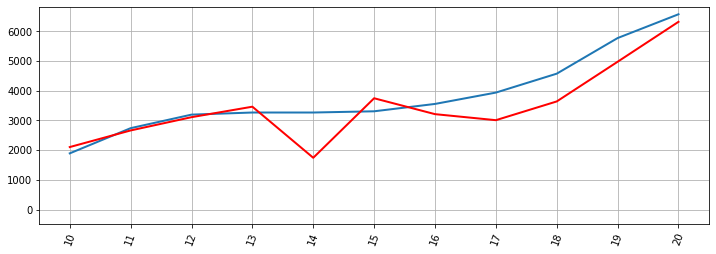

({'2018-10-23': [1892.0,
   2740.0,
   3196.0,
   3267.0,
   3267.0,
   3308.0,
   3556.0,
   3938.0,
   4575.0,
   5774.0,
   6575.0],
  '2018-10-24': [362.0,
   362.0,
   780.0,
   1739.0,
   2249.0,
   2482.0,
   2638.0,
   2898.0,
   3509.0,
   4100.0,
   4555.0],
  '2018-10-25': [923.0,
   1588.0,
   2183.0,
   3394.0,
   3933.0,
   4314.0,
   4565.0,
   4901.0,
   5705.0,
   6555.0,
   7172.0],
  '2018-10-29': [1115.0,
   1659.0,
   2539.0,
   2994.0,
   3130.0,
   3470.0,
   3646.0,
   4266.0,
   4814.0,
   5107.0,
   5731.0],
  '2018-10-31': [1088.0,
   1739.0,
   2461.0,
   3298.0,
   3836.0,
   3964.0,
   4099.0,
   4270.0,
   4414.0,
   5199.0,
   6100.0],
  '2018-11-01': [1026.0,
   1577.0,
   2408.0,
   3381.0,
   5347.0,
   6429.0,
   7935.0,
   9638.0,
   11578.0,
   13482.0,
   15222.0],
  '2018-11-02': [1205.0,
   1702.0,
   2456.0,
   3690.0,
   4245.0,
   5082.0,
   5326.0,
   5430.0,
   5976.0,
   6699.0,
   7313.0],
  '2018-11-03': [407.0,
   776.0,
   899.0,
   12

In [11]:
%%time
# 2. test with one file - histogram generate
histogram_generate(df)

0.012658227848101266 5848.101265822785


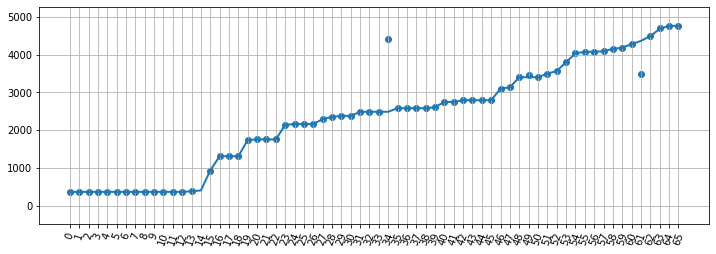

CPU times: user 844 ms, sys: 97.2 ms, total: 941 ms
Wall time: 777 ms


In [70]:
%%time
# 2. test with one file - salient point generate
# 날짜 별로 데이터 쪼개기
# df[['Date']] == df.iloc[i,2] == df.apply(lambda row: str(row['Date']), axis = 1)

all_date_dict = dict()

for date in dates:
    cur_date_list = []
    for row in df.itertuples(index=True, name='Pandas'):
        if getattr(row, 'Date')==date:
            cur_date_list.append(getattr(row, 'Steps'))
    all_date_dict[date] = cur_date_list
# all_date_dict.keys()

graph_compare(all_date_dict[dates[1]], lap_mechanism_gamma(all_date_dict[dates[1]]), 1)

# 모든 날짜의 sp를 담은 dict
# all_date_sp_dict = dict()
# for key in all_date_dict.keys():
#     all_date_sp_dict[key] = sp_generate(all_date_dict[key])
# graph_compare(all_date_dict[dates[0]], all_date_sp_dict[dates[0]], 1)

In [72]:
%%time
print('==  Paillier Homomorphic Encryption Scheme  ==\n\n>> Generating Ciphertext..')
pa = Paillier()
pa.setKey(pa.pub_key, pa.priv_key)
encrypted_data_list = pa.enc(lap_mechanism_gamma(all_date_dict[dates[1]]))
print('>> Encrypt Complete.\n>> Please Wait for function check..')
pa.func_chk(lap_mechanism_gamma(all_date_dict[dates[1]]))
print('>> Function Check Complete.')
# for data in encrypted_data_list:
#     print(pa.priv_key.decrypt(data))
# graph_compare(all_date_dict[dates[1]], ), 1)

==  Paillier Homomorphic Encryption Scheme  ==

>> Generating Ciphertext..
0.012658227848101266 5848.101265822785
>> Encrypt Complete.
>> Please Wait for function check..
0.012658227848101266 5848.101265822785
original data sum : 158162.0 encrypted data sum : 158162.0
original data average : 2396.0 encrypted data average : 2396.0
>> Function Check Complete.
CPU times: user 22.2 s, sys: 0 ns, total: 22.2 s
Wall time: 22.2 s


In [ ]:
# #various method to iterate dataframe
# #1
# for i in range(len(df)):
#     for date in dates:
#         cur_date = date
#         if df.iloc[i, 2] == cur_date:
#             pass
#             #날짜가 같을 동안 blahblah
#         else:
#             cur_date = df.iloc[i, 2]
#             print('date changed!')
#         print(date)
# #2
# for row_dict in df.to_dict(orient='records'):
#     for date in dates:
#         cur_date = date
#         cur_date_list = []
#         if row_dict['Date'] == cur_date:
#             for i in range(slot_size):
#                 cur_date_list.append(row_dict['Steps'])
#         else:
#             cur_date = row_dict['Date']
#             print('date changed')
#         print(date)
# #3
# for row in df.itertuples(index=False, name='Pandas'):
#     cur_date_dict=dict()
#     for date in dates:
#         cur_date = date
#         if getattr(row, 'Date') == cur_date:
#             pass
#         else:
#             cur_date = getattr(row, 'Date')
#             for i in range(slot_size):
#                 cur_date_dict[i] = getattr(row, 'Steps')
#             print(cur_date_dict)
#             print('date changed')
#         print(date)

In [ ]:
# 3. test with one file
# #5배 복제
# duplicated_df = pd.DataFrame(columns=['Steps', 'Timestamp', 'Date', 'Datetime', 'Hour'])

# for i in range(5):
#     duplicated_df = duplicated_df.append(df, ignore_index=True)

# duplicated_df

# # 전체 날짜 평균 데이터 구하는 코드
# avg_data = np.zeros(slot_size)
# duplicated_df.index = np.arange(1, len(duplicated_df)+1)

        
# # for i in range(len(avg_data)):
# #     print(i)    
# for i in range(slot_size):
#     for j in range(len(duplicated_df)//slot_size):
# #         print(i+j*66, end=' ')
#         avg_data[i] += duplicated_df.iloc[i+(j*slot_size)]['Steps']

# avg_result = avg_data / slot_size
# del avg_data
# arr = np.rint(avg_result).astype('int32')

# plt.figure(1)
# # plt.ylim(-50, 50)
# plt.plot(arr, '-b')

# plt.show()

In [3]:
# import os
# from collections import defaultdict
# import datetime

# def filelist():
#     files = ['C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\' + x for x in os.listdir('C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data')]
#     print(files)

#     return files



# def open_file(filepath):
#     temp_stepdict = defaultdict(list)
#     three_stepdict = defaultdict(list)

#     f = open(filepath, 'r', encoding='utf-8')
#     lines = f.readlines()
#     for line in lines[1:]:
#         line = line.replace(",",";")
#         item = line.split(";")
#         date = item[2].strip()
#         temp_timestamp = datetime.datetime.fromtimestamp(int(item[1][0:-3])).strftime('%H')
#         if(int(temp_timestamp) > 9 and int(temp_timestamp) < 21):
#             temp_stepdict[date].append(int(item[0]))
#     temp_stepdict = {key:val for key, val in temp_stepdict.items() if (len(temp_stepdict[key]) == 66 and temp_stepdict[key][65] > 3000 and temp_stepdict[key][0] == 0)}

#     data_list = list(temp_stepdict.values())
#     print(data_list)

# #     for k,v in enumerate(data_list):
# #         for i in range(1,65):
# #             temp = []
# #             #n1
# #             temp.append(data_list[k][0])
# #             if (n > 2):
# #                 #n2
# #                 temp.append(data_list[k][i])
# #             #n3
# #             temp.append(data_list[k][65])

# #             three_stepdict[k].append(temp)

#     f.close()

#     return three_stepdict, data_list
# files = filelist()
# for file in files:
#     open_file(file)

['C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\hjstep(2018.10~2019.2).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\hjstep(2019.3).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\hjstep(2019.4).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\hjstep(2019.5).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2018.11).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2018.12).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2019.2).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2019.3).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2019.4).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2019.5).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\Python\\eHealthPython\\data\\kndstep(2019.6).csv', 'C:\\Users\\dlsrk\\Desktop\\MyProj\\

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 21, 21, 320, 364, 2177, 2177, 2177, 2177, 2177, 2177, 2205, 2205, 2205, 2205, 2205, 2215, 2215, 3420, 4232, 4293]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 991, 1005, 1005, 1005, 1005, 1051, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 2194, 2194, 2194, 2194, 2194, 2194, 2235, 4118, 4227, 4337, 4485, 4542, 4626, 4715, 4715, 4787, 5087, 5087, 5556, 5850, 5850, 5850, 5850]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 474, 474, 474, 474, 474, 474, 474, 692, 692, 692, 692, 692, 692, 816, 2378, 2464, 2780, 3661, 3661, 3661, 4097, 4097, 4097, 4097, 4097, 4097, 4258, 4357, 4357, 4357], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 519, 519, 519, 519, 519, 519, 614, 1139, 1508, 1508, 1508, 1508, 2037, 2087, 2087, 20

[[0, 0, 0, 0, 0, 32, 177, 378, 553, 1000, 1292, 1592, 1592, 1592, 1592, 2295, 2397, 2397, 2397, 2397, 2397, 2685, 3614, 4339, 4415, 4643, 4796, 4796, 4796, 5017, 5626, 5753, 5753, 5753, 5753, 5753, 5753, 6304, 6519, 6853, 6853, 6853, 6853, 6864, 6864, 6864, 7040, 7565, 8022, 8022, 8022, 8022, 8022, 8022, 8141, 8510, 8619, 8619, 8619, 8619, 8619, 8619, 8619, 8738, 8808, 8808], [0, 0, 0, 0, 30, 177, 282, 484, 579, 706, 911, 1425, 1684, 1684, 1684, 1684, 1976, 2006, 2006, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2029, 2129, 2197, 2197, 2197, 2197, 2197, 2197, 2280, 2556, 2795, 3370, 3589, 3589, 3589, 3589, 3653, 3698, 3758, 3798, 4105, 4105, 4105, 4551, 5113, 5261, 5261, 5277, 5277, 5277, 5277, 5277, 5277, 5277, 5277, 5277], [0, 0, 0, 0, 0, 0, 207, 372, 407, 571, 738, 874, 1279, 1473, 1473, 1473, 1713, 1763, 1913, 2455, 2683, 2735, 2749, 2749, 2749, 2749, 2749, 2749, 2777, 2777, 2777, 2777, 2777, 2777, 2900, 2910, 2910, 2910, 2910, 2910, 2910, 2910, 3027, 3052, 30

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 32, 32, 162, 261, 312, 312, 312, 312, 373, 424, 459, 459, 459, 491, 740, 792, 1124, 1476, 1489, 1578, 1578, 1726, 1802, 1815, 2510, 2882, 2882, 2882, 2905, 2905, 2905, 2943, 2963, 3071, 3250, 4118, 4350, 4350, 4360, 4360, 4360, 4360, 4360, 4360, 4372, 4372, 4372, 4372, 4372, 4372, 4372, 4372], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 124, 193, 455, 944, 1216, 1241, 1388, 1658, 1658, 1658, 1658, 1658, 1819, 2084, 2896, 3051, 3351, 3679, 3870, 4111, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 4364, 4921, 5683, 5941, 5941, 5941, 5941, 5941, 5941, 5941, 5941, 5941, 5953, 6067, 6067, 6067, 6067, 6067, 6198, 6198, 6198], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 364, 364, 677, 718, 718, 718, 718, 718, 949, 1076, 1220, 1355, 2250, 3007, 3111, 3111, 3111, 3466, 3685, 3760, 3760, 3771, 3771, 3771, 3771, 3771, 3771, 3771, 3771, 3771, 3771, 3771, 3835, 3835, 3835, 3835, 3935, 4042, 4440, 4901, 4964, 5707, 5996, 6613, 6894